[413.09842693 531.11086696 218.17855418 383.1207039 ]


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


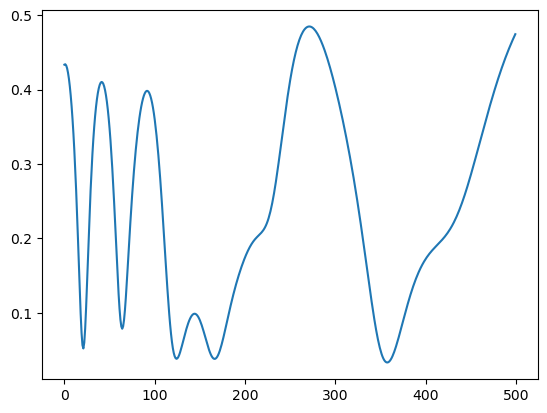

In [2]:
import sys
sys.path.append('./../../designer/script/')
from gets.get_spectrum import get_spectrum_simple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
import numpy as np
import copy
import matplotlib.pyplot as plt

WLS = np.linspace(500, 1000, 500)
INC_ANG = 60.
layer_number = 4
seed = 3

np.random.seed(seed)
d = np.random.random(layer_number) * 3000 / layer_number
print(d)
f = FilmSimple('SiO2', 'TiO2', 'SiO2', d)
f.add_spec_param(INC_ANG, WLS)
f.calculate_spectrum()
spec = f.get_spec().get_R()

np.savetxt(f"generaetd_spectrum-INC_ANG{INC_ANG}-WLS{WLS[0]}to{WLS[-1]}-R_{layer_number}layers_seed{seed}.txt", spec)
plt.plot(spec)



In [4]:
print("n TiO2 at 750 nm", f.get_spec().n[250, 1])
print("n SiO2 at 750 nm", f.get_spec().n[250, 0])
print(f.get_optical_thickness(750))

n TiO2 at 750 nm (2.5334627507835505+0j)
n SiO2 at 750 nm (1.5393841396519676+0j)
(3288.09872243223+0j)


In [3]:
# reflection film
num = 500
wls = np.linspace(400, 1200, num) / 1000
R = np.ones(num, dtype=float)
np.savetxt('generated_spectrum_reflection_400-1200nm.txt', R)
np.savetxt('wls_400-1200nm.txt', wls)

(0.0, 1.1)

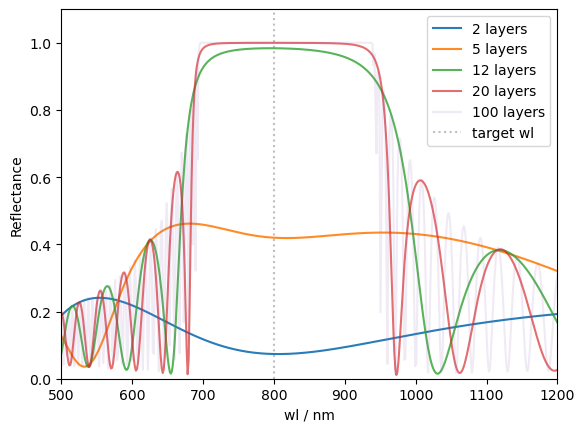

In [3]:
from gets.get_n import get_n_TiO2, get_n_SiO2

layer_numbers = [2, 5, 12, 20, 100]
f_demo = FilmSimple('SiO2', 'TiO2', 'SiO2', np.array([100]))
wl = 800 # nm

fig, ax = plt.subplots(1, 1)
wls = np.linspace(500, 1200, 500)
for layer_number in layer_numbers:
    d = np.array([wl / (4 * get_n_SiO2(wl)), wl / (4 * get_n_TiO2(wl))] * (layer_number // 2))    
    f = FilmSimple('SiO2', 'TiO2', 'SiO2', d)
    f.add_spec_param(0., wls)
    f.calculate_spectrum()
    alpha = np.exp(-layer_number / 50)
    ax.plot(wls, f.get_spec().get_R(), label=f'{layer_number} layers', alpha=alpha)
y_m = 1.1


ax.plot([wl, wl], [0, y_m], label='target wl', ls=':', alpha=0.5, c='grey')

ax.legend()
ax.set_xlabel('wl / nm')
ax.set_ylabel('Reflectance')
ax.set_xlim(wls[0], wls[-1])
ax.set_ylim(0, y_m)



0.4006564362544285


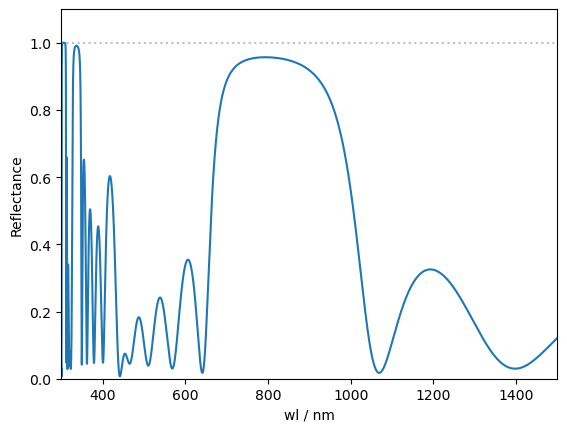

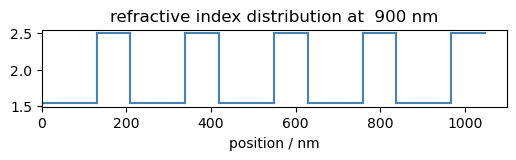

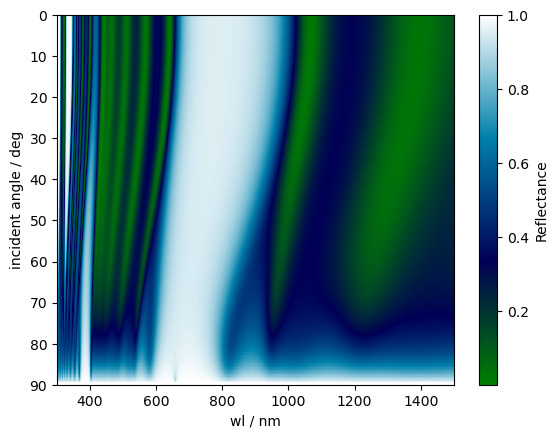

In [7]:
# generate film
layer_number = 10
d = np.array([wl / (4 * get_n_SiO2(wl)), wl / (4 * get_n_TiO2(wl))] * (layer_number // 2))    
f = FilmSimple('SiO2', 'TiO2', 'SiO2', d)


# plot R-wl
wls_new = np.linspace(300, 1500, 10000)
f.add_spec_param(0., wls_new)
f.calculate_spectrum()
spec = f.get_spec(0., wls_new).get_R()

fig, ax = plt.subplots(1, 1)
ax.plot(wls_new, spec)
ax.plot([wls_new[0], wls_new[-1]], [1, 1], ls=':', c='grey', alpha=0.5)
ax.set_ylabel('Reflectance')
ax.set_xlabel('wl / nm')
ax.set_ylim(0, 1.1)
ax.set_xlim(wls_new[0], wls_new[-1])


# calculate efficiency
AUC = spec.mean() * (wls_new[-1] - wls_new[0])
eff = AUC / (wls_new[-1] - wls_new[0])
print(eff)


# plot structure
from utils.structure import plot_layer_thickness
plot_layer_thickness(f)

'''
- This is a well designed film. Many other runs are trapped in local minimums.

- Sharp transmission only occurs in samll wl region

- Layer structure similar to that of back-reflectors (run #120), 
or "modulated" ones as proposed in (run #198)
    J. Krc, M. Zeman, S. L. Luxembourg, and M. Topic , "Modulated photonic-crystal structures as broadband back reflectors in thin-film solar cells", 
    Appl. Phys. Lett. 94, 153501 (2009) https://doi.org/10.1063/1.3109781

- Deep inside the film, less ordered
'''


# calculate dependence on both ang and wl
def calc_wl_ang(film: FilmSimple, wls: np.array, angs: np.array=np.linspace(0, 90., 100)):
    '''
    params:
        angs: angles at which the reflection will be calculated. In degree!
    '''
    f = copy.deepcopy(film)
    for s in f.get_all_spec_list():
        f.remove_spec_param(s.INC_ANG)

    arr = np.empty((angs.shape[0], wls.shape[0]))
    for i in range(angs.shape[0]):
        f.add_spec_param(angs[i], wls)
        f.calculate_spectrum()
        assert f.get_spec(angs[i], wls).is_updated()
        arr[i, :] = f.get_spec(angs[i], wls).get_R()

    return arr

arr = calc_wl_ang(f, wls_new, )

fig, ax = plt.subplots(1, 1)
s = ax.imshow(
    arr, 
    cmap='ocean', 
    aspect='auto', 
    extent=[wls_new[0], wls_new[-1], 90, 0]
) # NOTE: the image is interpolated
ax.set_xlabel('wl / nm')
ax.set_ylabel('incident angle / deg')
cbar = fig.colorbar(s)
cbar.set_label('Reflectance')